In [1]:
%reset -fs

In [2]:
import pandas as pd
import numpy as np
import string
import re
import spacy
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
from matplotlib import pyplot as plt
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import minmax_scale
%matplotlib inline

C:\Users\nated\anaconda3\lib\site-packages\matplotlib_inline\config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [3]:
stop_words = text.ENGLISH_STOP_WORDS.union(['nof', 'nthe', 'nand', 'nto', 'nin', 'nit', 'nfor', 'na', 'nthat', 'nbe', 'applause', 'nwhich', 'nis', 'nare', 'ni', 'nnot', 'nby', 'nhave', 'nbut', 'nwe', 'nwith', 'nfrom', 'nwill', 'nhas', 'nan', 'nif', 'nour'])

In [4]:
df = pd.read_csv('sotu_texts.csv')
df

,President,Year,Title,Text
0,George Washington,1790,First State of the Union Address,['I embrace with great satisfaction the opport...
1,George Washington,1790,Second State of the Union Address,['Fellow-Citizens of the Senate and the House ...
2,George Washington,1791,Third State of the Union Address,['Fellow-Citizens of the Senate and the House ...
3,George Washington,1792,Fourth State of the Union Address,['Fellow-Citizens of the Senate and of the Hou...
4,George Washington,1793,Fifth State of the Union Address,['Fellow Citizens of the Senate and of the Hou...
...,...,...,...,...
215,Barack Obama,2016,Barack Obama's Eighth State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ..."
216,Donald Trump,2017,Donald Trump's First State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ..."
217,Donald Trump,2018,Donald Trump's Second State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ..."
218,Donald Trump,2019,Donald Trump's Third State of the Union Address,"['Madam Speaker, Mr. Vice President, Members o..."


In [5]:
alphanumeric = lambda x: re.sub(r'\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

df['new_text'] = df.Text.map(alphanumeric).map(punc_lower)

In [6]:
nlp = spacy.load("en_core_web_sm")
docs = nlp.pipe(df.Text)

In [7]:
docs_clean = [[w.lemma_.lower() for w in doc if (not w.is_stop and not w.is_punct and not w.like_num)] for doc in docs]
df['docs_clean'] = docs_clean

In [8]:
docs_list_clean = [' '.join(doc) for doc in docs_clean]


In [9]:
count_vec = CountVectorizer(stop_words=stop_words, ngram_range=(1,3), min_df=2, max_df=219)
count_vec_X = count_vec.fit_transform(docs_list_clean)

In [10]:
num_topics = 10
SVD_topics = TruncatedSVD(num_topics)
doc_topic = SVD_topics.fit_transform(count_vec_X)

In [11]:
topic_word = pd.DataFrame(SVD_topics.components_.round(3),
             columns = count_vec.get_feature_names_out())

In [12]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [13]:
display_topics(SVD_topics, count_vec.get_feature_names_out(), 10)


Topic  0
government, year, congress, united, united states, country, great, law, people, nation

Topic  1
program, year, world, new, work, need, help, america, nation, federal

Topic  2
program, dollar, year, fiscal, fiscal year, war, united, expenditure, policy, united states

Topic  3
man, law, dollar, business, service, court, legislation, national, department, need

Topic  4
administration, energy, policy, congress, united states, effort, area, continue, provide, development

Topic  5
year, work, report, department, american, america, secretary, cent, office, fiscal year

Topic  6
mexico, united, war, united states, american, texas, mexican, army, foreign, peace

Topic  7
mexico, public, country, bank, department, congress, texas, business, constitution, tariff

Topic  8
mexico, year, country, texas, law, increase, man, mexican, land, number

Topic  9
world, free, great, year, department, report, secretary, war, increase, peace


In [14]:
tfidf_vec = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,3), min_df=2, max_df=219)
tfidf_X = tfidf_vec.fit_transform(docs_list_clean)

In [15]:
doc_topic = SVD_topics.fit_transform(tfidf_X)

In [16]:
display_topics(SVD_topics, tfidf_vec.get_feature_names_out(), 10)


Topic  0
government, year, congress, united, united states, country, people, great, nation, law

Topic  1
america, job, tonight, world, help, program, americans, new, people, year

Topic  2
program, economic, federal, world, problem, national, farm, increase, development, need

Topic  3
cent, year, work, department, law, court, silver, secretary, business, report

Topic  4
man, war, interstate, great, law, corporation, business, work, good, industrial

Topic  5
war, world, fight, man, united, enemy, free, nations, soviet, japanese

Topic  6
government, mexico, people, constitution, texas, bank, duty, kansas, congress, power

Topic  7
iraq, terrorist, iraqi, terror, al, regime, al qaeda, qaeda, saddam, afghanistan

Topic  8
war, enemy, bank, fiscal year, treasury, year, silver, debt, fiscal, cent

Topic  9
war, spain, job, british, enemy, production, year, mexico, japanese, construction


In [17]:
LDA_topics = LatentDirichletAllocation(n_components=10)

In [18]:
count_vec_X = count_vec.fit_transform(docs_list_clean)

In [19]:
doc_topic = LDA_topics.fit_transform(count_vec_X)

In [20]:
display_topics(LDA_topics, count_vec.get_feature_names_out(), 10)


Topic  0
instruction minister, embargo, gun boat, chesapeake, minister london, funded debt, instruction minister london, lay enable, enable meet current, indian neighbor

Topic  1
set foot, spirit inimical, defense congress, create society, man individual, effort design, nation grateful, denmark, american grit, historic commitment

Topic  2
government, law, great, country, year, man, congress, united, united states, work

Topic  3
year, world, nation, people, government, new, congress, program, need, work

Topic  4
government, united, united states, congress, year, country, great, public, law, present

Topic  5
set foot, spirit inimical, defense congress, create society, man individual, effort design, nation grateful, denmark, american grit, historic commitment

Topic  6
america, job, americans, work, tonight, year, child, people, american, new

Topic  7
loss damage, award commissioner, damage sustain, commissioner act article, damage, act article treaty, act article, capture condemna

In [21]:
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(LDA_topics, count_vec_X, count_vec, mds='mmds')

C:\Users\nated\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\nated\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.161506 -0.097624       1        1  50.520135
3     -0.267854 -0.037616       2        1  25.586147
2     -0.228321  0.121067       3        1  19.397408
6      0.001400 -0.273905       4        1   4.365415
0      0.122411  0.053501       5        1   0.088732
7      0.106631  0.052427       6        1   0.034703
1      0.106810  0.045538       7        1   0.001865
5      0.106810  0.045538       8        1   0.001865
8      0.106810  0.045538       9        1   0.001865
9      0.106810  0.045538      10        1   0.001865, topic_info=                      Term         Freq        Total Category  logprob  \
4860               america  1530.000000  1530.000000  Default  30.0000   
123142                work  2545.000000  2545.000000  Default  29.0000   
80734               people  3985.000000  3985.000000  Default  28.0000   
124356                year  6084.000000  6084.000000  Default  27.0000   
74229                  new  2805.000000  2805.000000  Default  26.0000   
...                    ...          ...          ...      ...      ...   
103616       session enact     0.000175     2.316921  Topic10 -11.7411   
114038  thoroughly discuss     0.000175     2.316921  Topic10 -11.7411   
101338          school aid     0.000175     2.316921  Topic10 -11.7411   
10676    believe enactment     0.000175     3.273838  Topic10 -11.7411   
5030          america live     0.000175     3.312213  Topic10 -11.7411   

        loglift  
4860    30.0000  
123142  29.0000  
80734   28.0000  
124356  27.0000  
74229   26.0000  
...         ...  
103616   1.3991  
114038   1.3991  
101338   1.3991  
10676    1.0534  
5030     1.0417  

[733 rows x 6 columns], token_table=        Topic      Freq             Term
term                                    
749         1  0.431607    accord pledge
749         3  0.431607    accord pledge
879         1  0.803244  account receipt
1175        1  0.631124              act
1175        2  0.198853              act
...       ...       ...              ...
124328      3  0.976603       wrongdoing
124356      1  0.450180             year
124356      2  0.372767             year
124356      3  0.129680             year
124356      4  0.047335             year

[854 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 7, 1, 8, 2, 6, 9, 10])

In [22]:
tfidf_X = tfidf_vec.fit_transform(docs_list_clean)

In [23]:
doc_topic = LDA_topics.fit_transform(tfidf_X)

In [24]:
display_topics(LDA_topics, tfidf_vec.get_feature_names_out(), 10)


Topic  0
income taxis, rights, gasoline, world free, incredible, spokesman, nitrogen, purpose free people, serbia, bad happen

Topic  1
income taxis, rights, gasoline, world free, incredible, spokesman, nitrogen, purpose free people, serbia, bad happen

Topic  2
income taxis, rights, gasoline, world free, incredible, spokesman, nitrogen, purpose free people, serbia, bad happen

Topic  3
income taxis, rights, gasoline, world free, incredible, spokesman, nitrogen, purpose free people, serbia, bad happen

Topic  4
program, america, help, job, tonight, americans, today, world, budget, child

Topic  5
government, year, congress, united, country, united states, great, nation, people, law

Topic  6
income taxis, rights, gasoline, world free, incredible, spokesman, nitrogen, purpose free people, serbia, bad happen

Topic  7
income taxis, rights, gasoline, world free, incredible, spokesman, nitrogen, purpose free people, serbia, bad happen

Topic  8
income taxis, rights, gasoline, world free, 

In [25]:
pyLDAvis.sklearn.prepare(LDA_topics, tfidf_X, tfidf_vec, mds='mmds')

C:\Users\nated\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\nated\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.022181  0.031320       1        1  81.752147
4      0.008411 -0.011200       2        1  16.450296
0      0.001761 -0.002486       3        1   0.224695
1      0.001685 -0.002542       4        1   0.224695
2      0.001687 -0.002540       5        1   0.224695
3      0.001753 -0.002492       6        1   0.224695
6      0.001747 -0.002496       7        1   0.224695
7      0.001684 -0.002542       8        1   0.224695
8      0.001739 -0.002502       9        1   0.224695
9      0.001714 -0.002520      10        1   0.224695, topic_info=                       Term      Freq     Total Category  logprob  loglift
47853            government  8.000000  8.000000  Default  30.0000  30.0000
4860                america  1.000000  1.000000  Default  29.0000  29.0000
87910               program  0.000000  0.000000  Default  28.0000  28.0000
51846                  help  0.000000  0.000000  Default  27.0000  27.0000
21275              congress  5.000000  5.000000  Default  26.0000  26.0000
...                     ...       ...       ...      ...      ...      ...
45416             free base  0.000171  0.058846  Topic10 -11.7411   0.2569
89132       propose certain  0.000171  0.059120  Topic10 -11.7411   0.2522
84517          power defeat  0.000171  0.058709  Topic10 -11.7411   0.2592
121550          war release  0.000171  0.061220  Topic10 -11.7411   0.2173
81493   people world people  0.000171  0.059431  Topic10 -11.7411   0.2470

[597 rows x 6 columns], token_table=        Topic      Freq           Term
term                                  
1175        1  1.120104            act
4860        1  0.760569        america
4860        2  0.760569        america
5171        1  1.044456       american
5605        2  1.533196      americans
16314       1  0.797358        citizen
21275       1  1.057195       congress
25348       1  1.016634        country
29612       1  0.957863     department
33228       1  0.824696           duty
34056       1  0.779612       economic
44220       1  0.994212          force
46687       1  0.887526        general
47460       1  1.131438           good
47853       1  0.996748     government
49601       1  1.045456          great
51846       2  1.230157           help
55690       1  1.032170       increase
59783       2  1.607722            job
62179       1  1.064040            law
66692       1  0.915402            man
71365       1  0.892645         nation
72072       1  1.175209       national
73097       1  0.974031      necessary
74229       1  1.019003            new
80136       1  0.818340          peace
80734       1  0.868508         people
84394       1  0.932146          power
85451       1  0.959565        present
87910       2  1.172015        program
89906       1  1.014251        provide
90544       1  1.130210         public
99535       1  0.800386          right
103161      1  0.879605        service
103941      1  1.069109          shall
110197      1  1.163868        subject
112642      1  1.041575            tax
114273      1  1.067044           time
115087      2  1.716164        tonight
116300      1  0.918809         treaty
118049      1  0.966218         united
118085      1  1.025580  united states
121156      1  0.873482            war
123142      1  0.741814           work
123755      1  0.742229          world
124356      1  0.919187           year, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 1, 2, 3, 4, 7, 8, 9, 10])

In [26]:
doc_word = count_vec.fit_transform(docs_list_clean)
words = list(np.asarray(count_vec.get_feature_names_out()))

In [27]:
topic_model = ct.Corex(n_hidden=10, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=docs_list_clean)

In [28]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: appointment,interested,states government,interstate commerce,promptly,local self government,local self,commend,united states government,pan
1: fight,set,school,training,legislation enact,enact,deficit,recognize,diplomacy,criminal
2: history,attendance,substantial,end june expenditure,total number,shortly submit,rate year,profitably,year increase,evil
3: imputation,thousand mile,concede,duty united,duty united states,colleague,congress far,result policy,congress proper,rebate
4: cash receipt,joy,scrip,challenge time,grateful acknowledgment,present administration,june expenditure,land warrant,locate military,congress exercise
5: ideology,ask join,commence,social security medicare,productive,industrial country,job job,year special,close communication,adventurer
6: pro,tenure office,ireland,bring attention congress,able meet,principle public,force nation,national safety,genius,assess
7: happy effect,social political,student loan,great improvement,cancer,tax incentive,demand government,l

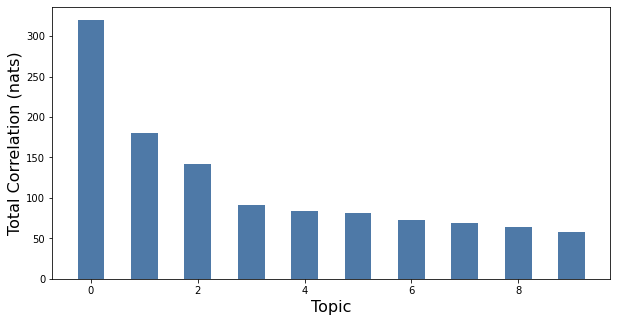

In [29]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [30]:
topic_model = ct.Corex(n_hidden=10, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=docs_list_clean, anchors=[['economy', 'job', 'work', 'program', 'employment'], ['manufacturing', 'production', 'build', 'commerce', 'business', 'farmer', 'agriculture', 'crop', 'private business', 'farm', 'land'], ['government', 'america', 'american', 'people', 'constitution', 'country', 'congress', 'united', 'people', 'nation', 'federal'], ['money', 'expenditure', 'tax', 'fiscal', 'treasury', 'stimulus', 'income', 'dollar', 'currency', 'tariff', 'debt', 'cent', 'bank', 'home'], ['protest', 'race', 'movement', 'strike', 'black', 'indian', 'latino', 'slave', 'civil','right','liberty', 'immigration', 'mexico', 'dreamer', 'citizenship'], ['germany', 'france', 'spain', 'nato', 'europe', 'hitler', 'japan', 'japanese', 'nazi', 'putin', 'ukraine', 'korea', 'soviet', 'ukraine', 'british', 'cuba', 'venezuela', 'iran', 'china', 'russia', 'canada', 'war', 'fight', 'vietnam', 'alliance', 'adversary', 'enemy', 'international', 'german', 'navy', 'military', 'troop', 'sea power', 'admiral', 'general', 'iraqi', 'iraq', 'insurgent', 'terrorist', 'saddam', 'kuwait', 'syria', 'israel', 'panama', 'army', 'peace', 'afghanistan', 'al qaeda', 'taliban', 'islamic', 'defense', 'treaty'], ['energy', 'atomic', 'renewable', 'oil', 'research', 'science', 'innovation', 'cyber', 'space', 'moon', 'rocket', 'cancer', 'health', 'industrial', 'pandemic'], ['law', 'order', 'court', 'crime', 'gang', 'police', 'safe', 'gun', 'sedition', 'communist', 'communism'], ['college', 'school', 'education', 'degree', 'math', 'student',  'education', 'university'], ['road', 'bridge', 'airplane', 'interstate', 'airport', 'highway', 'port', 'dock', 'shipyard', 'railway', 'infrastructure']], anchor_strength=2)

In [31]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: job,program,today,goal,economic,budget,help,house representatives,basic,representatives
1: manufacturing,production,crop,present law,advocate,widely,farmer,requirement,business,import
2: american,successor,tenure,america,ask,set apart,genius,example,tenure office,follow
3: cent,currency,expenditure,fiscal,tariff,year end june,interior,fiscal year end,treasury,end june
4: mexico,civil,indian,protest,constitute,report secretary navy,class,compose,tribunal,complaint
5: china,rule,russia,germany,navy,england,japanese,army,provide appointment,cuba
6: research,long term,affordable,big,energy,street,cancer,help people,health,renewable
7: crime,safe,police,communism,pay,teach,gun,half,bring cost,prison
8: student,school,education,college,deficit,university,young,enforcement,chamber,record
9: interstate,railway,bridge,road,highway,company,criminal,department justice,strongly,municipal


In [32]:
vt.vis_rep(topic_model, column_label=words, prefix='sotu-model')

Print topics in text file


C:\Users\nated\anaconda3\lib\site-packages\fontTools\misc\py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


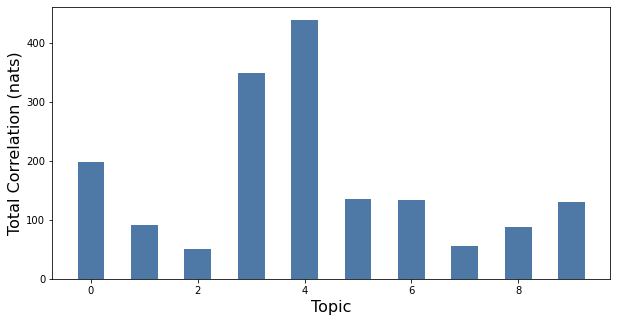

In [33]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);
plt.savefig('topic_graph.png')

In [34]:
predictions = pd.DataFrame(topic_model.log_p_y_given_x, columns=['Economy/Labor', 'Economy/Manufacturing', 'Government/Federalism/States', 'Finances/Budget', 'Social Issues', 'Foreign Policy', 'Science and Technology', 'Crime/Law/Jurisprudence', 'Education', 'Infrastructure'])
predictions

,Economy/Labor,Economy/Manufacturing,Government/Federalism/States,Finances/Budget,Social Issues,Foreign Policy,Science and Technology,Crime/Law/Jurisprudence,Education,Infrastructure
0,-689.738980,-349.766783,-182.122179,-1667.878714,-1360.908642,-435.978261,-433.098832,-179.135363,-343.955667,-397.587301
1,-897.082529,-365.653721,-150.812359,-1556.692449,-1365.351732,-421.669513,-436.501720,-181.037151,-350.069661,-409.954968
2,-1557.782044,-337.104070,-179.095535,-1315.516377,-1326.465336,-422.959144,-461.232172,-417.342391,-387.136335,-383.259366
3,-1421.375162,-345.651227,-187.271937,-1345.175120,-1329.894841,-423.954361,-422.136710,-360.833771,-374.093101,-396.610285
4,-1346.571151,-356.527798,-183.451244,-1304.028064,-1328.095852,-391.534050,-466.872228,-349.182676,-369.837029,-401.402680
...,...,...,...,...,...,...,...,...,...,...
215,0.000000,0.000000,0.000000,-1719.060672,0.000000,0.000000,0.000000,-61.382014,0.000000,-401.574824
216,0.000000,-380.233803,0.000000,-1689.332182,-1355.397915,0.000000,0.000000,0.000000,0.000000,0.000000
217,0.000000,-333.958551,-203.124105,-1643.048879,-1340.934517,-413.421395,0.000000,0.000000,0.000000,0.000000
218,0.000000,-354.765901,0.000000,-1678.457599,-1346.945037,0.000000,0.000000,0.000000,0.000000,0.000000


In [43]:
predictions_scaled = minmax_scale(np.array(predictions.values.T)).T
preds_df = pd.DataFrame(predictions_scaled, columns=['Economy/Labor', 'Economy/Manufacturing', 'Government/Federalism/States', 'Finances/Budget', 'Social Issues', 'Foreign Policy', 'Science and Technology', 'Crime/Law/Jurisprudence', 'Education', 'Infrastructure'])
mtx = preds_df.values

In [44]:
maren = KMeans(n_clusters=10, random_state=42)

In [45]:
maren.fit(mtx)

KMeans(n_clusters=10, random_state=42)

In [46]:
preds_df['Cluster'] = maren.labels_

In [47]:
preds_df.Cluster.value_counts()

2    63
1    30
6    27
0    25
7    21
4    17
3    15
8    12
5     6
9     4
Name: Cluster, dtype: int64

In [48]:
df_clusters = preds_df.groupby(['Cluster']).median()
df_clusters

,Economy/Labor,Economy/Manufacturing,Government/Federalism/States,Finances/Budget,Social Issues,Foreign Policy,Science and Technology,Crime/Law/Jurisprudence,Education,Infrastructure
Cluster,,,,,,,,,,
0,1.0,0.829005,0.871256,0.000000,0.015986,0.705120,0.711099,0.656506,0.745153,0.736052
1,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.859585,0.822467,0.911657,0.949652
2,1.0,0.802931,0.879502,0.000000,0.157351,0.746808,1.000000,1.000000,1.000000,0.755994
3,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
4,0.0,0.856936,1.000000,1.000000,0.174799,0.789954,0.654355,1.000000,0.710835,0.791756
5,1.0,0.761145,0.912185,1.000000,0.675294,0.876091,0.374650,1.000000,0.000000,0.673000
6,0.0,0.883179,1.000000,0.146045,0.169362,0.832808,0.796790,0.864919,0.838632,0.830372
7,0.0,0.870973,1.000000,1.000000,1.000000,0.755654,0.525607,1.000000,0.558176,1.000000
8,1.0,1.000000,0.925103,1.000000,0.000000,0.837067,0.815220,0.717900,1.000000,1.000000


In [49]:
[[num[0] for num in df_clusters.iloc[1].values.reshape(-1, 1).tolist()]]

[[0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.859585330537029,
  0.8224672719237817,
  0.9116568338956268,
  0.9496520496728752]]

In [50]:
top_3_docs = pairwise_distances([[num[0] for num in df_clusters.iloc[1].values.reshape(-1, 1).tolist()]], \
                                mtx,metric='euclidean').argsort()[0, :3]
df['Cluster']=maren.labels_

In [55]:
df.iloc[top_3_docs[2]]

President                                         James K. Polk
Year                                                       1846
Title                         Second State of the Union Address
Text          ['Fellow-Citizens of the Senate and of the Hou...
new_text        fellow citizens of the senate and of the hou...
docs_clean    [fellow, citizens, senate, house, representati...
Cluster                                                       1
Name: 50, dtype: object

In [56]:
preds_df.iloc[top_3_docs[2]]

Economy/Labor                   0.000000
Economy/Manufacturing           1.000000
Government/Federalism/States    1.000000
Finances/Budget                 1.000000
Social Issues                   1.000000
Foreign Policy                  1.000000
Science and Technology          1.000000
Crime/Law/Jurisprudence         0.720126
Education                       0.689349
Infrastructure                  1.000000
Cluster                         1.000000
Name: 50, dtype: float64

In [59]:
dfs = [df.drop(columns=['Cluster']), preds_df]
df_1 = pd.concat(dfs, axis=1)

In [60]:
df_1

,President,Year,Title,Text,new_text,docs_clean,Economy/Labor,Economy/Manufacturing,Government/Federalism/States,Finances/Budget,Social Issues,Foreign Policy,Science and Technology,Crime/Law/Jurisprudence,Education,Infrastructure,Cluster
0,George Washington,1790,First State of the Union Address,['I embrace with great satisfaction the opport...,i embrace with great satisfaction the opport...,"[embrace, great, satisfaction, opportunity, pr...",0.657024,0.885386,0.997994,0.000000,0.206194,0.827477,0.829411,1.000000,0.889289,0.853264,2
1,George Washington,1790,Second State of the Union Address,['Fellow-Citizens of the Senate and the House ...,fellow citizens of the senate and the house ...,"[fellow, citizens, senate, house, representati...",0.469179,0.847184,1.000000,0.000000,0.136100,0.807340,0.796790,0.978501,0.858269,0.815672,6
2,George Washington,1791,Third State of the Union Address,['Fellow-Citizens of the Senate and the House ...,fellow citizens of the senate and the house ...,"[fellow, citizens, senate, house, representati...",0.000000,0.885392,1.000000,0.175722,0.167780,0.823119,0.795358,0.827193,0.849102,0.851914,6
3,George Washington,1792,Fourth State of the Union Address,['Fellow-Citizens of the Senate and of the Hou...,fellow citizens of the senate and of the hou...,"[fellow, citizens, senate, house, representati...",0.000000,0.871664,1.000000,0.061745,0.074127,0.808215,0.809688,0.859362,0.848618,0.830372,6
4,George Washington,1793,Fifth State of the Union Address,['Fellow Citizens of the Senate and of the Hou...,fellow citizens of the senate and of the hou...,"[fellow, citizens, senate, house, representati...",0.000000,0.851196,1.000000,0.036577,0.015884,0.821099,0.756327,0.857511,0.839754,0.812615,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,Barack Obama,2016,Barack Obama's Eighth State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ...",mr speaker mr vice president members of ...,"[mr., speaker, mr., vice, president, members, ...",1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.964293,1.000000,0.766399,2
216,Donald Trump,2017,Donald Trump's First State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ...",mr speaker mr vice president members of ...,"[mr., speaker, mr., vice, president, members, ...",1.000000,0.774921,1.000000,0.000000,0.197672,1.000000,1.000000,1.000000,1.000000,1.000000,2
217,Donald Trump,2018,Donald Trump's Second State of the Union Address,"['Mr. Speaker, Mr. Vice President, Members of ...",mr speaker mr vice president members of ...,"[mr., speaker, mr., vice, president, members, ...",1.000000,0.796745,0.876374,0.000000,0.183874,0.748382,1.000000,1.000000,1.000000,1.000000,2
218,Donald Trump,2019,Donald Trump's Third State of the Union Address,"['Madam Speaker, Mr. Vice President, Members o...",madam speaker mr vice president members o...,"[madam, speaker, mr., vice, president, members...",1.000000,0.788636,1.000000,0.000000,0.197510,1.000000,1.000000,1.000000,1.000000,1.000000,2


In [67]:
df_1.to_csv('sotu_clusters.csv')